#**I. Introduction**

In the previous explorations of Reinforcement Learning concepts embarked upon throughout this course, value functions and policies were stored in a tabular format. This is manageable when the 𝓢 x 𝓐 space, or environment, of consideration is relatively small and can be discretized. Practically speaking however, this approach breaks down when the 𝓢 x 𝓐 space increases in size. Tables become inefficient. Consequently, this approach must be abandoned in favour of one where tables are no longer needed, and the constraints associated with them can be relaxed. With that goal in mind, this is where Function Approximation comes into play. The aim is to have our agent explore its environment such that it will learn a function which will approximate its action value function. The function will be learned through use of a simple Neural Network (NNs), as this notebook will go on to demonstrate. This time around, the CartPole environment will be the subject of investigation. 

#**II. Imports and Installations** 

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
# Standard imports for 'gym' based RL projects
import gym
from IPython import display as ipythondisplay

# Imports from Exercise IV
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

# Additional imports required for this implementation
import copy 
import random

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

#**III. Randomly Acting Cartpole**

As usual, the performance of the randomly acting agent will be exhibited for us to compare against by the time Reinforcement Learning theory has been applied to this problem.

Iterations that were run: 11


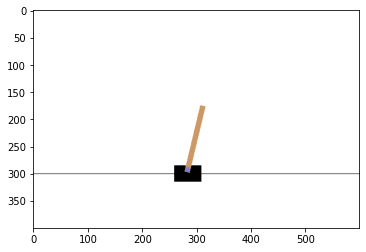

In [5]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  print(env.env.state)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:", i + 1)

#**IV. Helper Functions**

Below are found some helper functions which will help simplify readability of RL theory implementation.

##**2. Policy Helper Functions**

###ε-Greedy Policy State Update

In [6]:
# Updates ε-greedy policy for a specified state (i.e. calculate π(s))
def eps_greedy_policy_update(input_policy_state, eps = 0.1):

  # Determine the amount of actions that can be taken to go from current
  # state to another state (|𝒜(s)|)
  act_set_size = len(input_policy_state)

  # Determine the maximum probability of taking an action for a given state
  optimal_value = max(input_policy_state.values())

  # Determine which actions out of the state's action set |𝒜(s)|
  # are optimal, based on the calculated optimal value
  optimal_actions = [action for action in input_policy_state if input_policy_state[action] == optimal_value]     

  # Initialize sub dictionary of the action set for the soft policy
  soft_policy_action_set = {}
    
  # Loop through each action possible in the current state
  for action in input_policy_state:
    
    # The following if statements intend to assign probabilities of taking
    # actions in given states in accordance with the ε-soft requirements
    if action in optimal_actions:

      if len(optimal_actions) != act_set_size:
        # When the optimal value in an action set is > 0
        # When all actions for a given state are not equiprobable,
        # Set the probability of taking the optimal action to be = (1/|𝒜'(s)|)(1 - ε) + ε/|𝒜(s)|
        # Where |𝒜'(s)| represents the number of optimal actions within |𝒜(s)| (i.e. ties)
        soft_policy_action_set[action] = (1/len(optimal_actions))*(1 - eps) + eps/act_set_size

      else:
        # Otherwise, if all actions in |𝒜(s)| are equiprobable,
        # and not equal to 0, they shall remain equiprobable
        soft_policy_action_set[action] = (1/len(optimal_actions))

    else:
      # For non optimal actions, set the probability of taking
      # these actions = ε/|𝒜(s)|
      soft_policy_action_set[action] = eps/act_set_size

  # Return the ε policy for a given state
  return soft_policy_action_set

##**3. Function Approximation Helper Functions**

###Neural Network Input Size Function

In [7]:
# This is a function used to determine the input size required for the Neural
# Network (NN) based on the size of the state tuple and action input combined
def NN_input(environment):

  # Calculate size of state tuple for environment
  state_tuple_size = environment.env.observation_space.shape[0] 
  
  # Calculate action input size 
  action_input_size = 1

  # Calculate input size requireed for the model
  model_input_size = state_tuple_size + action_input_size

  # Return the model's required input dimension
  return model_input_size

###Neural Network Output Generator

In [8]:
# The following functon takes the current state (described by a tuple of 
# variables) and the selected action at this state (described by an integer),
# combines them into an input for the Neural Network (NN) being used for 
# function approximation. The output of the NN, returned by this function,
# is the approximated action value for the given state-action pair. 
def NN_output(state, action, model):

  # Append the state tuple and action into a single array for input into the 
  # neural network
  state_action_input = np.append([np.array(state)], [[action]], axis = 1)

  # Store the output of the model into the 'output variable'
  output = model(state_action_input)

  # Return the model's output
  return output

###Reset Model Weights to Previous Value

In [9]:
# Function to reset model weights; use prior to running algorithm, given that
# the current run and former runs are executed in the same runtime
# The weights to which the model must be reset will need to be specified
def reset_weights(input_model, initial_weights):
  input_model.set_weights(initial_weights)

  # Return model with weights reset
  return input_model

###Custom Weight Initialization

In [10]:
# Function to quickly reinitialize model weights whenever required - as 
# implemented currently, weights can either be initialized to 0 or to the 
# form of a Gaussian distribution for a specified mean and standard deviation
def initialize_model_weights(model, initialization = 'gaussian', mean = 0, std_dev = 1):

  # variable for error handling unsupportable inputs for the 'initialization
  # parameter
  initialization_error = False

  # Initialize list to store the weights to apply to the 
  # model
  weights_list = []

  # The following for loop will leave biases untouched
  # and will update weights such that they follow a Gaussian 
  # distribution of values with mean and standard deviation
  # as specified by the 'loc' and 'scale' parameters of the 
  # 'np.random.normal' function
  for x in range(0,len(model.weights)):
    
    # Identifying the term 'kernel' in the model name will 
    # indicate that the following entry in the current 
    # 'model.weights' list represents the weights, and not
    # the bias of a particular layer
    if 'kernel' in model.weights[x].name:

      # Determine the appropriate shape for the updated
      # weights based on the current shape of the weights
      weights_shape = model.get_weights()[x].shape

      # update weights
      if initialization == 'gaussian':
        weight = np.random.normal(loc = mean, scale = std_dev, size = weights_shape)

      elif initialization == 'zero':
        weight = np.zeros(shape = weights_shape)

      else:
        print('\'', initialization, '\' is an invalid initialization type...' )
        print('Choose \'initialization\' parameter to be \'zeros\' or \'gaussian\'')
        break

      # append to weight_list used to finally update current model 
      # weights
      weights_list.append(weight)
    
    else:
      # bias terms will be updated to a zero vector

      # Determine the appropriate shape for the updated
      # weights based on the current shape of the weights
      bias_shape = model.get_weights()[x].shape

      # update weights
      bias = np.zeros(shape =  bias_shape)

      # append to weight_list used to finally update current model 
      # weights
      weights_list.append(bias)

  # Update model weights as long as 'initialization' parameter input is valid

  if initialization_error == False:
    model.set_weights(weights_list)

  # Return updated model
  return model

##**4. TD Control Helper Functions**

###Reward Adjustment Function

**NOTE:** The built-in reward structure of the CartPole environment provided by OpenAI gym was modified such that a greater reward is provided to the agent when the pole's inclination angle from the vertical is less than or equal to 3 degree in either direction. Also a reward of 0 will be given if the CartPole transitions to the terminal state.

In [11]:
# Function to modify the reward attained by the agent depending on its current
# state
def reward_calculation(state, reward, done):

  # Extract individual variables representing the specified state
  position, velocity, theta_rad, ang_vel_rad = state

  # Convert the angle to degrees
  theta = np.degrees(theta_rad)

  # Reward increment to be applied when the agent's state meets certain criteria
  reward_increment = 7

  # For the cartpole environment, if the pole has an angle between -1 and 1 
  # degrees from the vertical then the reward is incremented accordingly
  if theta >= -1 and theta <= 1 and done == False:
    reward_mod = reward + reward_increment

  # If the agent has arrived at the terminal state, set the received reward to
  # -1
  elif done == True:
    reward_mod = -1

  # In all other cases, the reward shall remain unmodified
  else:
    reward_mod = reward

  # Return the resulting reward
  return reward_mod

###Episode Verdict Evaluator

In [12]:
# Function used to determine if an episode was successful
def episode_verdict(state):

  # Extract state variables 
  position, velocity, theta_rad, ang_vel_rad = state

  # Convert theta from rad to degrees
  theta = np.degrees(theta_rad)

  # First to conditions represent a failed episode. Otherwise, successful 
  # episode
  if position > 2.4 or position < -2.4:
    episode_result = 0

  elif theta > 12 or theta < -12:
    episode_result = 0 

  else:
    episode_result = 1

  return episode_result

###SARSA(0) Algorithm (Based on Function Approximation)

In [13]:
def TD0_SARSA_FA(environment, model, error, optimizer, eps = 0.2, gamma = 0.95):

  # 'abort' is used to halt training process if it is discovered that the 
  # NN based function approximation is diverging to an unhelpful result
  # (i.e. action value predictions tending to infinity or equalizing, 
  # despite the action taken)
  abort = False

  # 'done' variable signifies if the condition for stopping an episode (excluding
  # successfully episodes) has been met
  done = False

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []
  
  # Initialize an error list which will store the average per prediction error
  # in an episode
  error_list = []

  # Reset environment before processing episode
  environment.reset()

  # Set the initial state of the environment
  state = environment.env.state

  # Take initial episode action based on ε-greedy policy
  action = action_selection_NN(environment, state, model, eps)

  # Check to see if the neural network is providing problematic results
  abort = divergent_NN_test(environment, state, model)

  # If problematic results are observed, exit the function early
  if abort:
    episode_result = 0
    return model, reward_list, episode_result, error_list, optimizer, abort

  # Loop for each step of the episode
  while done == False:

    # Take the selected action, and observe the next state and resulting 
    # reward
    obs, reward, done, info = environment.step(action)

    # Store the state arrived at in a variable
    new_state = environment.env.state

    # Calculate reward, modified depending on the state to which the mountain 
    # car has transitioned - inspect the 'reward_calculation' function for greater
    # detail
    reward = reward_calculation(new_state, reward, done)

    # Append reward to a reward list, used to summarize training
    reward_list.append(reward)

    # If the next state is terminal, update weights of the neural network 
    # approximation of action value function
    if done:
      with tf.GradientTape() as tape:

        # Set approximated action value to the output of constructed neural
        # network for state-action pair at timestep τ
        q_hat = NN_output(state, action, model)

        # Set per prediction error to be measured between estimated return
        # given the current state-action pair and the neural network based
        # action value function approximation
        return_pred = tf.constant(reward, shape = (1, 1), dtype = float)

        ppError = error(return_pred, q_hat)

      # Determine gradient of function approximation
      q_hat_grad = tape.gradient(ppError, model.trainable_weights)  

      # Update model weights
      optimizer.apply_gradients(zip(q_hat_grad, model.trainable_weights))

      # Store error in list to summarize results of training  when implementing
      # TD control
      error_list.append(ppError.numpy())

      # If terminal state is to be arrived at, exit the function
      break

    # Select new action based on new state
    new_action = action_selection_NN(environment, new_state, model, eps)

    # Check to see if the neural network is providing problematic results
    abort = divergent_NN_test(environment, new_state, model)

    # If problematic results are observed, exit the function early
    if abort:
      break

    # Update weights of the model
    with tf.GradientTape() as tape:

      # Set approximated action value to the output of constructed neural
      # network for state-action pair at timestep τ
      q_hat_new = NN_output(new_state, new_action, model)
      q_hat = NN_output(state, action, model)

      # Set per prediction error to be measured between estimated return
      # given the current state-action pair and the neural network based
      # action value function approximation
      return_pred = tf.constant(reward + gamma * q_hat_new, shape = (1, 1), dtype = float)

      ppError = error(return_pred, q_hat)

    # Determine gradient of function approximation
    q_hat_grad = tape.gradient(ppError, model.trainable_weights)  

    # Update model weights
    optimizer.apply_gradients(zip(q_hat_grad, model.trainable_weights))

    # Store error in list to summarize results of training  when implementing
    # TD control
    error_list.append(ppError.numpy())

    # Update state and action
    state, action = new_state, new_action

  # Determine through 'episode_verdict' function whether or not episode is 
  # a success or failure
  episode_result = episode_verdict(environment.env.state)

  return model, reward_list, episode_result, error_list, optimizer, abort

###SARSA(n) Algorithm (Based on Function Approximation)

In [14]:
# N-Step SARSA algorithm adapted for function approximation
def N_STEP_SARSA_FA(environment, model, error, optimizer, n = 1, eps = 0.2, gamma = 0.95):

  # 'abort' is used to halt training process if it is discovered that the 
  # NN based function approximation is diverging to an unhelpful result
  # (i.e. action value predictions tending to infinity or equalizing, 
  # despite the action taken)
  abort = False

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []
  
  # Initialize an error list which will store the average per prediction error
  # in an episode
  error_list = []
  state_action_reward_list = []

  # Ensure the environment is reset before processing an episode
  environment.reset()

  # generate initial state and action
  state = environment.env.state

  # Take initial episode action based on ε-greedy policy
  action = action_selection_NN(environment, state, model, eps)

  # Check to see if the neural network is providing problematic results
  abort = divergent_NN_test(environment, state, model)

  # If problematic results are observed, exit the function early
  if abort:
    episode_result = 0
    return model, reward_list, episode_result, error_list, optimizer, abort

  # Initialize timestep variable, 't' to zero - terminal timestep 'T'
  # initialized to infinity - this is done to ensure that 't' will always be
  # less than 'T', allowing for episode to be properly processed. Actual 'T'
  # will eventually be determined if episode terminates due to 'done' condition
  # being met
  t = 0
  T = float(np.inf)

  while True:

    # If current timestep is not the terminal step, enter the if 
    # statement to take the next action
    if t < T:
      
      # Extract variables associated with taking an action
      obs, reward, done, info = environment.step(action)

      # Calculate reward, modified depending on the state to which the mountain 
      # car has transitioned - inspect the 'reward_calculation' function for greater
      # detail
      reward = reward_calculation(state, reward, done)

      # Store initial state action and reward
      state_action_reward_list.append((state, action, reward))

      # Append to reward list used to summarize results of training when 
      # implementing TD control
      reward_list.append(reward)

      # Update 'state' variable to the state arrived at after taking 
      # 'action'
      state = environment.env.state

      # If the next state is terminal, update 'T', which represents the 
      # terminal timestep
      if done:
        T = t + 1
      
      else:
        # Take action based on ε-greedy policy, as long as terminal state has
        # not yet been reached
        action = action_selection_NN(environment, state, model, eps)

        # Check to see if the neural network is providing problematic results
        abort = divergent_NN_test(environment, state, model)

        # If problematic results are observed, exit the function early
        if abort:
          break

    # tau is intended to represents timesteps for which action value 
    # updates can be made; when the quantity tau is non-negative 
    # (starting at tau = 0), the return at timestep tau can be estimated 
    # using the n steps taken by the agent in the environment
    tau = t - n + 1

    # Enter the loop only when τ (tau) is >= 0 (i.e. when enough 
    # states have been visited to estimate n-step returns)
    if tau >= 0:

      # Initialize the return variable to 0 prior to its calculation
      G = 0

      # For the return calculation, we need to check that the current 
      # timestep τ + n (number of steps after τ) is equal to or less than 
      # T - cannot calculate returns beyond T
      end_step = min(tau + n, T)

      # Calculate first component of estimate for return using n 
      # rewards achieved beyond τ
      for i in range(tau, end_step):

        # Reward achieved when transitioning from state i - 1 to i
        reward_i = state_action_reward_list[i][2]

        # Update returns computation with these n rewards and γ (gamma)
        G += tf.constant((gamma**(i - tau)) * reward_i, shape = (1, 1), dtype = float)

      # If the timestep τ + n is not the terminal timestep T, enter
      # the if statement and update the return to estimate for the 
      # remaining terms of the return calculation
      if tau + n < T:

        # Extract the state and action stored at timestep τ + n
        state_tau_n, action_tau_n = state, action

        # Complete our estimate of the return using our estimated
        # action value function value at the state and action for 
        # timestep τ + n

        # Extract neural network output 
        q_hat_tau_n = NN_output(state_tau_n, action_tau_n, model)

        # Convert neural network output from tensor to scalar value 
        q_hat_tau_n_val = q_hat_tau_n.numpy()[0][0]

        # Compute return
        G += tf.constant((gamma**n) * q_hat_tau_n_val, shape = (1, 1), dtype = float)

      # Extract the state and action stored at timestep τ
      state_tau, action_tau, _ = state_action_reward_list[tau]

      with tf.GradientTape() as tape:
        
        # Set approximated action value to the output of constructed neural
        # network for state-action pair at timestep τ
        q_hat = NN_output(state_tau, action_tau, model)

        # Set per prediction error to be measured between estimated return
        # given the current state-action pair and the neural network based
        # action value function approximation
        ppError = error(G, q_hat)

      # Determine gradient of function approximation
      q_hat_grad = tape.gradient(ppError, model.trainable_weights)  

      # Store error in list to summarize results of training  when implementing
      # TD control
      error_list.append(ppError.numpy())

      # Update model weights
      optimizer.apply_gradients(zip(q_hat_grad, model.trainable_weights))
  
    # If the timestep τ is the step just before reaching
    # the terminal state, exit the algorithm
    if tau == T - 1:

      break

    # Increment timestep variable t
    t += 1
  
  # Determine if episode is successful or not
  episode_result = episode_verdict(environment.env.state)

  return model, reward_list, episode_result, error_list, optimizer, abort

In [15]:
def action_selection_NN(environment, state, model, eps):

  # Initialize a dictionary that will represent the different action values
  # at the current state
  action_value_state = {}

  # For each action choice in the space of action choices, determine the 
  # action value 
  for action_choice in range(environment.env.action_space.n):
    action_value_state[action_choice] = NN_output(state, action_choice, model).numpy()[0][0]
  
  # From the current state, extract the possible actions and their corresponding
  # weights, according to ε-greedy policy
  state_policy = eps_greedy_policy_update(action_value_state, eps)

  # Extract possible actions at the state
  action_set = list(state_policy.keys())
  
  # Extract action weights based on 
  action_weights = list(state_policy.values())

  # Probabilistically choosen an action based on each action's weight, 
  # according to ε-greedy policy
  selected_action = random.choices(action_set, action_weights, k = 1)[0]

  return selected_action

###Divergent FA Testing Function

In [16]:
# Function used to determine if Function Approximation is diverging to a 
# problematic result 
def divergent_NN_test(environment, state, model):
  
  # Parameter to abort action selection if the NN appears to diverge to produce
  # problematic outputs (i.e. exactly equal action values or action values
  # diverging to infinity)
  abort = False

  # Initialize a dictionary that will represent the different action values
  # at the current state
  action_value_state = {}

  # For each action choice in the space of action choices, determine the 
  # action value 
  for action_choice in range(environment.env.action_space.n):
    action_value_state[action_choice] = NN_output(state, action_choice, model).numpy()[0][0]
  
  # From the dictionary extract a list of only the action values
  action_value_state_list = list(action_value_state.values())

  # Use the list created to see if action values are exactly equal 
  # irregardless of the action taken at the current state
  action_value_comparison = [1 if action_value_state_list[0] == action_value_state_list[x] else 0 for x in range(len(action_value_state_list))]

  # If it is found that the action values are diverging to infinity, abort the
  # action selection process
  if np.isinf(action_value_state_list).any() or np.isnan(action_value_state_list).any():
    print('>> WARNING - Training has stopped as it appears prediction action-value function is diverging to infinity')
    print('>> Please reinitialize weights, adjust hyperparameters, and retry the algorithm')
    abort = True

  # If it is found that the action values have converged to being exactly 
  # equal irrespective of chosen action, abrot the action selection process
  elif sum(action_value_comparison) == len(action_value_state_list):
    print('>> WARNING - Training has stopped as it appears approximate action values have become equal regardless of action taken at state')
    print('>> Please reinitialize weights, adjust hyperparameters, and retry the algorithm')
    abort = True


  return abort

###TD-Control Function

In [17]:
# TD Control Function
def TD_CONTROL(environment, model, error, optimizer, n = 0, eps = 0.2, gamma = 0.95, episode_count = 5000, batch_printout = False):

  lr_initial = optimizer.lr.numpy()
  lr_decay = 0.01
  minimum_lr = 3e-4

  lr_update_step = 50

  lr_minimum_reached = False

  eps_decay = 0.99
  minimum_eps = 0.05

  eps_update_step = 50

  eps_minimum_reached = False

  # Parameter representing the maximum number of episodes possible in an episode
  # DO NOT CHANGE
  max_episode_steps = 200

  # Set a batch size for which updates on training will be reported through a 
  # print statement
  batch_size = 100

  # Initialize lists that will be used to provide statistics on the training
  # of the model
  total_reward = []
  total_episode_length = []
  total_episode_result = []
  average_episode_error_list = []

  # Loop the selected method for each episode
  for episode in range(0, episode_count):

    if n > 0:
      model, reward_list, episode_result, error_list, optimizer, abort = N_STEP_SARSA_FA(environment = environment, model = model, error = error, optimizer = optimizer, n = n, eps = eps, gamma = gamma)
    
    else:
      model, reward_list, episode_result, error_list, optimizer, abort = TD0_SARSA_FA(environment = environment, model = model, error = error, optimizer = optimizer, eps = eps, gamma = gamma)
    
    if abort:
      print('>> Hyperparameter Combination: lr = ', optimizer.lr.numpy(), ', gamma = ', gamma, ', eps = ', eps)

      break

    if eps_minimum_reached == False:

      if (episode + 1) % eps_update_step == 0:

        if eps > minimum_eps:
          eps = eps * eps_decay

          if eps <= minimum_eps:
            eps = minimum_eps
            eps_minimum_reached = True

    
    if lr_minimum_reached == False:

      if (episode + 1) % lr_update_step == 0:
        
        if optimizer.lr > minimum_lr:
          optimizer.lr = lr_initial * (1/(1 + lr_decay * (episode + 1)))

          if optimizer.lr <= minimum_lr:
            optimizer.lr = minimum_lr
            lr_minimum_reached = True

    # For each episode, sum up the rewards, retrieve the number of episode steps,
    # retrieve the episode outcome (success or failure), and retrieve the 
    # average per prediction error for the episode; store these into 
    # lists which will be used to summarize overall training statistics
    #print(reward_list)
    total_reward.append(sum(reward_list))
    total_episode_length.append(len(reward_list))
    total_episode_result.append(episode_result)
    average_episode_error_list.append(sum(error_list)/len(error_list))

    # Report training statistics only when a batch is completed
    if (episode + 1) % batch_size == 0:
      #print(policy)
      # Print number of episodes completed and the total number of episodes
      # for which training will run, as specified by the 'episode_count' 
      # parameter

      if batch_printout == True:
        print(episode + 1, ' episodes completed... out of ', episode_count, '*' * 40)

      # Calculate the average reward attained in episodes from the first episode
      # to the current episode
      total_avg_reward = sum(total_reward)/len(total_reward)

      # Calculate the average episode length from the first episode
      # to the current episode
      total_avg_episode_length = sum(total_episode_length)/len(total_episode_length)

      # Calculate the number of successful episodes from the first episode to
      # the current episode
      episode_result_cumulative = sum(total_episode_result)

      # Calculate the average of average errors from the first episode to the
      # current episode
      average_episode_error_cumulative = sum(average_episode_error_list)/len(average_episode_error_list)

      # Calculate the three statistics determined above except this time only 
      # compute them for the episodes within the batch just completed
      batch_avg_reward = sum(total_reward[(episode + 1 - batch_size):(episode + 1)])/batch_size
      batch_avg_episode_length = sum(total_episode_length[(episode + 1 - batch_size):(episode + 1)])/batch_size
      episode_result_batch = sum(total_episode_result[(episode + 1 - batch_size):(episode + 1)])
      average_episode_error_batch = sum(average_episode_error_list[(episode + 1 - batch_size):(episode + 1)])/batch_size

      if batch_printout == True:
        # Display current learning rate 𝛼 and and 𝜀 for 𝜀-greedy policy
        print(' Current Learning Rate and Exploration Factor')
        print('   Current Learning Rate - alpha (𝛼): ', optimizer.lr.numpy())
        print('   Current Exploration Factor - epsilon (𝜀): ', eps, '\n')

        # Display the results of the statistics calculated above - first the 
        # cumulative statistics, then the results for the batch
        print(' Cumulative Statistics:')

        # Total average reward attained
        print('   Cumulative Average Reward = ', total_avg_reward)

        # Average episode length along with its fractional length (out of max
        # possible episode length)
        print('   Cumulative Average Episode Length = ', total_avg_episode_length, '/', max_episode_steps, ' (', total_avg_episode_length/max_episode_steps, ')')     
        
        # Number of successful episodes (out of all episodes)
        print('   Cumulative Successful Episode Count = ', episode_result_cumulative, '/', len(total_episode_result), ' (',  episode_result_cumulative/len(total_episode_result), ')')     

        # Average per prediction error between function approximation and 'actual' value function
        print('   Cumulative Average of Average Per Prediction Episode Error = ', average_episode_error_cumulative, ' (Avg. over', len(average_episode_error_list), 'episodes)')     

        # Similar description of statistics, but this time just pertaining to the
        # batch
        print('\n Batch Statistics (episodes ', (episode + 1) - batch_size + 1, ' to ', episode + 1, '):')
        print('   Batch Average Reward = ', batch_avg_reward)
        print('   Batch Average Episode Length = ', batch_avg_episode_length, '/', max_episode_steps, ' (', batch_avg_episode_length/max_episode_steps, ')')           
        print('   Batch Successful Episode Count = ', episode_result_batch, '/', batch_size, ' (', episode_result_batch/batch_size, ')') 
        print('   Batch Average of Average Per Prediction Episode Error = ', average_episode_error_batch, ' (Avg. over', batch_size, 'episodes)\n')
    # If all episodes in the episode_count have been run, training is complete
    # and method, selected parameters, and final results will be displayed
    if episode + 1 == episode_count:

      print('-' * 81)
      print('𝐓𝐑𝐀𝐈𝐍𝐈𝐍𝐆 𝐂𝐎𝐌𝐏𝐋𝐄𝐓𝐄')
      
      # Determine how to display chosen TD control method based on user 
      # inputs to the relevant parameters ('n' and 'method') 
      selected_method = 'n-SARSA (n = ' + str(n) + ')'

      # Print the selected method
      print('ᴛᴅ-ᴄᴏɴᴛʀᴏʟ ᴍᴇᴛʜᴏᴅ:')
      print(' ', selected_method)

      # Print the training hyperparameters used
      print('\nᴘᴀʀᴀᴍᴇᴛᴇʀꜱ:')
      print(' Final Learning rate (𝜶) = ', optimizer.lr.numpy()) 
      print(' Discount Factor (𝜸) = ', gamma)
      print(' Final 𝜀-greedy constant (𝜺) = ', eps)
      
      # Print cumulative statistics after all episodes have run
      print('\nꜱᴜᴍᴍᴀʀʏ ꜱᴛᴀᴛɪꜱᴛɪᴄꜱ:')
      
      # Create a list with the episode lengths for the successful episodes only
      successful_episodes = [total_episode_length[x] for x in range(0, len(total_episode_length)) if total_episode_result[x] == 1]
      
      # Calculate the average of episode length for successful episodes only
      avg_successful_episode_length = sum(successful_episodes)/len(successful_episodes) if len(successful_episodes) !=0 else 0
      
      # Display average episode length including failed episodes
      print(' Cumulative Average Episode Length = ', total_avg_episode_length, '/', max_episode_steps, ' (', total_avg_episode_length/max_episode_steps, ')')
      
      # Display average episode length excluding failed episodes
      print(' Cumulative Average Successful Episode Length: ', avg_successful_episode_length, '/', max_episode_steps, ' (', avg_successful_episode_length/max_episode_steps, ')')
      
      # Display the count of successful episodes 
      print(' Cumulative Successful Episode Count = ', episode_result_cumulative, '/', len(total_episode_result), ' (',  episode_result_cumulative/len(total_episode_result), ')')     

      # Display cumulative average of average errors between NN based action
      # value function and estimation of action value function
      print(' Cumulative Average of Average Per Prediction Episode Error = ', average_episode_error_cumulative, ' (Avg. over', len(average_episode_error_list), 'episodes)')    

  # Return the final policy and action value function after all episodes in the
  # episode count have run
  return model

##**5. Performance Assessment**

###CartPole Performance Simulation

In [29]:
# Function to demonstrate performance of agent
def CartPole_TEST(model, trial_count, episode_count, eps = 0.1, display_trial_readout = True, display_episode_readout = True):

  # QUICK DEFINITION: trial - a group of episodes
  # 'episode_count': this parameter represents how many episodes are in each 
  # trial

  # Episodes can only last 200 timesteps - do not change this variable
  max_episode_length = 200

  # Length of timesteps for each trial (trial is a set of episodes)
  trial_step_count = episode_count * max_episode_length

  # Generate the MC environment
  env = gym.make("CartPole-v0")

  # Initialize lists which will store 
  successful_episode_average_list = []
  successful_episode_count_list = []
  episode_average_list = []
  # Loop for each trial
  for trial in range(0, trial_count):
    
    # For each trial initialize a list into which the length of episodes will 
    # be stored
    episode_steps = []
 
    # Initialize a list which will indicate whether or not episodes have 
    # succeeded or failed
    successful_episode_bool = []

    # Loop for each episode within the trial
    for episode in range(0, episode_count):
      
      # Reset the environment before processing an episode 
      env.reset()
      for i in range(50000):

        # Choose an action and move forward to the next time step
        action = action_selection_NN(env, env.env.state, model, eps = eps)
        obs, reward, done, info = env.step(action)

        # If termination is reached, end the episode
        if done:
          break

      # Determine if episode is successful
      episode_result = episode_verdict(env.env.state)
      successful_episode_bool.append(episode_result)

      # Append the number of episode steps completed in an episode
      episode_steps.append(i + 1)

    # Create a list containing only the step counts for episodes that were 
    # successful 
    successful_episode_steps = [steps for success, steps in zip(successful_episode_bool, episode_steps) if success == 1]

    # Determine the average step count of successful episodes
    successful_episode_average = (sum(successful_episode_steps)/len(successful_episode_steps)) if len(successful_episode_steps) !=0 else 0
    
    # Determine the amount of successful episodes
    successful_episode_count = len(successful_episode_steps)

    # Determine the average length of all episodes
    episode_average = sum(episode_steps)/len(episode_steps)

    # Append the above calculations to a list that will store these measures
    # in order to average them over all trials
    successful_episode_average_list.append(successful_episode_average)
    successful_episode_count_list.append(successful_episode_count)
    episode_average_list.append(episode_average)


    # Here we will display the output of our calculations - output can be 
    # seen on an trial-by-trial basis - or, more granularly, an episode-by-
    # -episode basis. These can also both be turned off with the 'display_' + x
    # + '_readout' parameters to this function - when they are turned off only
    # the final cumulative statistics will be seen 
    if display_trial_readout == True or display_episode_readout == True:
      print('*****Trial ', trial + 1, ' (',episode_count, 'Episodes) *****************')

    if display_episode_readout == True: 
        
      for episode in range(0, episode_count):

        # Print whether episode has failed or succeeded
        print('\n Episode ', episode + 1, ':')

        if successful_episode_bool[episode] == 0:
          print('  FAILED EPISODE...')

        else:
          print('  SUCCESSFUL EPISODE...')

        # Print the length of the episode
        print('    Episode Length = ', episode_steps[episode], '/', max_episode_length)
        print('    Fractional Length = ', episode_steps[episode]/max_episode_length)

    if display_trial_readout == True:
      # For each trial, display the number of successful episodes and 
      # average successful episode length; they are also displayed in fraction-
      # al form with the print statements below
      print('Successful Episodes = ', sum(successful_episode_bool), '/', episode_count)
      print('Fraction of Successful Episodes = ', sum(successful_episode_bool)/episode_count)
      print('Average Successful Episode Length = ', successful_episode_average, '/', max_episode_length)
      print('Fraction Successful Episode Length = ', successful_episode_average/max_episode_length)
      print('Average Episode Length = ', episode_average, '/', max_episode_length)
      print('Fractional Average Episode Length = ', episode_average/max_episode_length, '\n')

  # Cumulative results from the trials are calculated here
  total_successful_episode_count = sum(successful_episode_count_list)
  total_successful_episode_average = sum(successful_episode_average_list)/len(successful_episode_average_list) if len(successful_episode_average_list) !=0 else 0
  total_episode_average = sum(episode_average_list)/len(episode_average_list)

  # Display cumulative statistics from the trial runs
  print('CUMULATIVE RESULTS:')
  print('Total Number of Successful Episodes = ', total_successful_episode_count, '/', (episode_count * trial_count))
  print('Fraction of Successful Episodes = ', total_successful_episode_count/(episode_count * trial_count))
  print('Average of Average Successful Episode Steps per Trial = ', total_successful_episode_average, '/', max_episode_length)
  print('Average of Average Successful Episode Steps per Trial (Fractional) = ', total_successful_episode_average/max_episode_length)
  print('Average of Average Successful Episode Steps per Trial = ', total_episode_average, '/', max_episode_length)
  print('Average of Average Episode Lengths per Trial (Fractional) = ', total_episode_average/max_episode_length)

#**V. Building the Neural Network for Function Approximation**

##**Model Architecture**

In [19]:
# Define dimension of input and output to the model
p_inputSpace = NN_input(env)
p_outputSpace = 1

# Construct the model 

# Input Layer 
inputs = keras.Input(shape= (p_inputSpace,), name= 'state-action-pair')

# First hidden layer - 256 neurons, tanh activation function
x1 = keras.layers.Dense(256, activation= 'tanh', name = 'hidden_layer_1')(inputs)

# Second hidden layer - 128 neurons, tanh activation function
x2 = keras.layers.Dense(128, activation= 'tanh', name = 'hidden_layer_2')(x1)

# Output layer
outputs = keras.layers.Dense(units = p_outputSpace, name= 'action-value')(x2)

# Assemble model after architecture has been specified
model = keras.Model(inputs = inputs, outputs = outputs)

##**Display Model Architecture Plot**

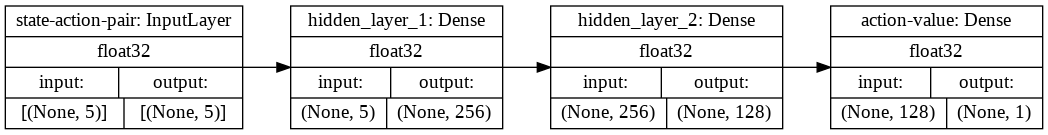

In [23]:
# plot a schematic of the model built in the previous code block
keras.utils.plot_model(
    
    # Specify the model to plot
    model = model,

    # Display inputs and outputs dimensions to layers
    show_shapes=True,

    # Display type for inputs and outputs of layers
    show_dtype=True,

    # Display provided names of layers
    show_layer_names=True,

    # Orientation of model plot 
    rankdir="LR", #TB: vertical; LR: hor
    expand_nested=True,
    
    # Dots per inch - size of model plot 
    dpi= 96,
)

##**Establish Optimizer Type and Error Metric**

In [24]:
# Optimizer and per-prediction error - SGD optimizer is being used in this case
#optimizer = keras.optimizers.SGD(learning_rate = alpha)

# Mean Squared Error will be used to determine the performance of the model
# In the context of a Reinforcement Learning problem such as this, estimated
# returns will be compared to the estimated action value generated by the 
# NN
f_ppError = keras.losses.MeanSquaredError() 

#**VI. n-SARSA With Function Approximation Implementation**

##**Initialized Inputs**

In [25]:
model = initialize_model_weights(model, initialization = 'gaussian', mean = 0, std_dev = 0.7)
weights_initial = model.get_weights()

##**SARSA(0) Training**

In [26]:
# Reinitialize model weights to the values generate with the
# 'initialize_model_weights' function
model = reset_weights(model, weights_initial)

alpha = 0.001

# Optimizer and per-prediction error - SGD optimizer is being used in this case
optimizer = keras.optimizers.SGD(learning_rate = alpha)

# Mean Squared Error will be used to determine the performance of the model
# In the context of a Reinforcement Learning problem such as this, estimated
# returns will be compared to the estimated action value generated by the 
# NN
f_ppError = keras.losses.MeanSquaredError() 

model_SARSA_0 = TD_CONTROL(env, model, f_ppError, optimizer = optimizer, n = 0, eps = 0.1, gamma = 0.92, episode_count = 1500, batch_printout = True)

100  episodes completed... out of  1500 ****************************************
 Current Learning Rate and Exploration Factor
   Current Learning Rate - alpha (𝛼):  0.0005
   Current Exploration Factor - epsilon (𝜀):  0.09801 

 Cumulative Statistics:
   Cumulative Average Reward =  102.61
   Cumulative Average Episode Length =  58.41 / 200  ( 0.29205 )
   Cumulative Successful Episode Count =  1 / 100  ( 0.01 )
   Cumulative Average of Average Per Prediction Episode Error =  9.709579006123057  (Avg. over 100 episodes)

 Batch Statistics (episodes  1  to  100 ):
   Batch Average Reward =  102.61
   Batch Average Episode Length =  58.41 / 200  ( 0.29205 )
   Batch Successful Episode Count =  1 / 100  ( 0.01 )
   Batch Average of Average Per Prediction Episode Error =  9.709579006123057  (Avg. over 100 episodes)

200  episodes completed... out of  1500 ****************************************
 Current Learning Rate and Exploration Factor
   Current Learning Rate - alpha (𝛼):  0.00033333

##**SARSA(0) Performance**

In [30]:
CartPole_TEST(model_SARSA_0, trial_count = 10, episode_count = 100, eps = 0.1, display_trial_readout = True, display_episode_readout = False)

*****Trial  1  ( 100 Episodes) *****************
Successful Episodes =  100 / 100
Fraction of Successful Episodes =  1.0
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  200.0 / 200
Fractional Average Episode Length =  1.0 

*****Trial  2  ( 100 Episodes) *****************
Successful Episodes =  98 / 100
Fraction of Successful Episodes =  0.98
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  199.82 / 200
Fractional Average Episode Length =  0.9991 

*****Trial  3  ( 100 Episodes) *****************
Successful Episodes =  99 / 100
Fraction of Successful Episodes =  0.99
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  198.53 / 200
Fractional Average Episode Length =  0.99265 

*****Trial  4  ( 100 Episodes) *****************
Successful Episodes =  100 / 100
Fraction of Successful Episode

##**SARSA(n) Training**

In [33]:
# Note hyperparameter tuning not done for SARSA(n) - but can be tested out
# if you like

# Reinitialize model weights
model = reset_weights(model, weights_initial)

# Reset learning rate
alpha = 0.0009

# Optimizer and per-prediction error - SGD optimizer is being used in this case
optimizer = keras.optimizers.SGD(learning_rate = alpha)

model_SARSA_N = TD_CONTROL(env, model, f_ppError, optimizer = optimizer, n = 2, eps = 0.1, gamma = 0.94, episode_count = 1500, batch_printout = True)

100  episodes completed... out of  1500 ****************************************
 Current Learning Rate and Exploration Factor
   Current Learning Rate - alpha (𝛼):  0.00045
   Current Exploration Factor - epsilon (𝜀):  0.09801 

 Cumulative Statistics:
   Cumulative Average Reward =  98.91
   Cumulative Average Episode Length =  56.53 / 200  ( 0.28265 )
   Cumulative Successful Episode Count =  0 / 100  ( 0.0 )
   Cumulative Average of Average Per Prediction Episode Error =  30.32558759806288  (Avg. over 100 episodes)

 Batch Statistics (episodes  1  to  100 ):
   Batch Average Reward =  98.91
   Batch Average Episode Length =  56.53 / 200  ( 0.28265 )
   Batch Successful Episode Count =  0 / 100  ( 0.0 )
   Batch Average of Average Per Prediction Episode Error =  30.32558759806288  (Avg. over 100 episodes)

200  episodes completed... out of  1500 ****************************************
 Current Learning Rate and Exploration Factor
   Current Learning Rate - alpha (𝛼):  0.0003
   Cur

##**SARSA(n) Performance**

In [34]:
CartPole_TEST(model_SARSA_N, trial_count = 10, episode_count = 100, eps = 0.1, display_trial_readout = True, display_episode_readout = False)

*****Trial  1  ( 100 Episodes) *****************
Successful Episodes =  19 / 100
Fraction of Successful Episodes =  0.19
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  127.43 / 200
Fractional Average Episode Length =  0.63715 

*****Trial  2  ( 100 Episodes) *****************
Successful Episodes =  26 / 100
Fraction of Successful Episodes =  0.26
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  135.17 / 200
Fractional Average Episode Length =  0.67585 

*****Trial  3  ( 100 Episodes) *****************
Successful Episodes =  19 / 100
Fraction of Successful Episodes =  0.19
Average Successful Episode Length =  200.0 / 200
Fraction Successful Episode Length =  1.0
Average Episode Length =  131.65 / 200
Fractional Average Episode Length =  0.65825 

*****Trial  4  ( 100 Episodes) *****************
Successful Episodes =  31 / 100
Fraction of Successful Ep

##**CartPole Single Trial Results**

In [ ]:
env.reset()

input_model = model_SARSA_0

for i in range(50000):
  action = action_selection_NN(env, env.env.state, input_model, eps = 0.0)
  print('state = ', env.env.state)

  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

  print('tau: ', env.env.tau)
  


  if done:
    break


env.close()
print("Iterations that were run:", i + 1)

In [ ]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

input_model = model_SARSA_0

for i in range(50000):
  action = action_selection_NN(env, env.env.state, input_model, eps = 0.0)
  print('state = ', env.env.state)

  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  print('tau: ', env.env.tau)
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:", i + 1)

#**VII. Conclusion**

Overall function approximation works quite well and is a practical alternative to tabular methods. However I find that results are far more sensitive to hyperparameter tuning compared to what was experienced with tabular methods.